# Regression (...continued)

## further methods & comparison

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import statsmodels.api as sm
import seaborn as sns
import pickle

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn.utils import resample


# Set up plotting options for seaborn and matplotlib
sns.set_context('notebook') 
sns.set_style('ticks') 
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [14]:
# load from previous lessons
cached_files = ['models/ames_train_y.pickle','models/ames_test_y.pickle',
                'models/ames_train_X.pickle','models/ames_test_X.pickle',
                'models/predictors.pickle','models/ames_ols_all.pickle',
                'models/ames_ridge.pickle','models/ames_lasso.pickle', 
                'models/ames_enet.pickle']

for file in cached_files:
    with open(file, 'rb') as f:
        objectname = file.replace('models/', '').replace('.pickle', '')
        exec(objectname + " = pickle.load(f)")
        f.close()

## Random Forest
In random forest, each tree in the ensemble is built from a bootstrap sample from the training set. In addition, when splitting a node during the construction of the tree, the split that is chosen is the best split among a random subset of the features. The scikit-learn implementation combines classifiers by averaging their probabilistic prediction, instead of letting each classifier vote for a single class.

In [15]:
from sklearn.pipeline import Pipeline

#alphas = list(np.logspace(-12, 10, 20, base=2))
ames_RF = Pipeline([
    ('scaler', StandardScaler()),
    #('estimator', LassoCV(alphas=alphas, cv=10)),
    ('estimator', RandomForestRegressor())
])

ames_RF.fit(ames_train_X, ames_train_y)

## Toggle comment below to build model
# ames_RF.fit(ames_train_X, ames_train_y)
pickle.dump(ames_RF, open('models/ames_rforest.pickle', 'wb'))
#with open('models/ames_rforest.pickle', 'rb') as f:
#    ames_RF = pickle.load(f)

In [16]:
best_alpha_RF = ames_RF.named_steps.estimator.alpha_
print(best_alpha_RF)

AttributeError: 'RandomForestRegressor' object has no attribute 'alpha_'

In [57]:
alphas.index(best_alpha_lasso)

1

> ## Challenge 1
>
> 1. Look at the coefficients for the model above. What was the balance between L1 (Lasso) and L2 (Ridge) regression?
> 2. What value of alpha was found to be optimal? Was this value expected based on the results we got when we ran Lasso and Ridge independently?
> 
> {: .source}
>
> > ## Solution
> > 
> > 2. See [this answer](https://stackoverflow.com/questions/47365978/scikit-learn-elastic-net-approaching-ridge) for an explanation why the 
> >  two values of alpha were not the same.
> > {: .output}
> {: .solution}
{: .challenge}

In [17]:
# What was the RMSE on the training data?
columns=['Train RMSE']
rows=['OLS','Ridge', 'Lasso', 'ENet', 'Random Forest']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[ames_ols_all, ames_ridge, ames_lasso, ames_enet, ames_RF]

for i, method in enumerate(methods):
    y_pred=method.predict(ames_train_X)
    results.iloc[i,0] = np.sqrt(mean_squared_error(10**ames_train_y, 10**y_pred))

results.round(3)

,Train RMSE
OLS,18810.886
Ridge,21330.847
Lasso,20365.796
ENet,21292.160
Random Forest,12752.869


In [19]:
# Compare with the test data!
columns=['Test RMSE']
rows=['OLS','Ridge', 'Lasso', 'ENet', 'Random Forest']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[ames_ols_all,  ames_ridge, ames_lasso, ames_enet, ames_RF]

for i, method in enumerate(methods):
    y_pred=method.predict(ames_test_X)
    results.iloc[i,0] = np.sqrt(mean_squared_error(10**ames_test_y, 10**y_pred))

results.round(3)

,Test RMSE
OLS,64792.914
Ridge,47670.165
Lasso,59592.173
ENet,52482.808
Random Forest,28046.717


In [23]:
def plot_coefficients(model, labels):
    #coef = model.coef_
    coef = model.feature_importances_

    table = pd.Series(coef.ravel(), index = labels).sort_values(ascending=True, inplace=False)
    
    reference = pd.Series(np.abs(coef.ravel()), index = labels).sort_values(ascending=False, inplace=False)
    reference = reference.iloc[:20]
    table = table[reference.index]
    table = table.sort_values(ascending=True, inplace=False)

    fig, ax = fig, ax = plt.subplots()
    table.T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    ax.tick_params(axis=u'y', length=0) 
    #ax.set_title('Estimated coefficients (twenty largest in absolute value)', fontsize=14)
    ax.set_title('Feature Importances (twenty largest in absolute value)', fontsize=14)
    sns.despine()
    return fig, ax

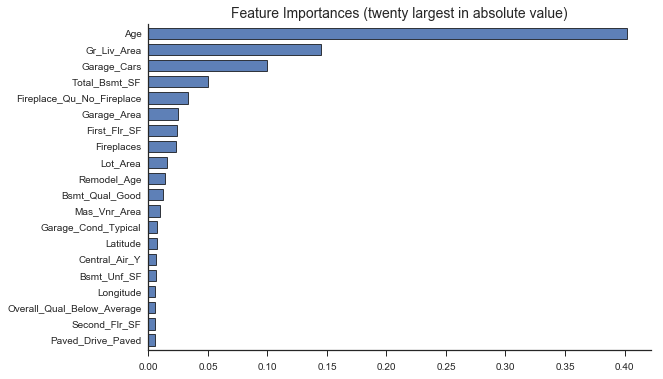

In [24]:
plot_coefficients(ames_RF._final_estimator, predictors)# the final_estimator attribute refers to the pipeline
plt.show()

## k-Nearest Neighbours Regression

In [127]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline



# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.

linreg = LinearRegression()
pca = PCA()

pipe = Pipeline(steps=[('pca', pca), ('linreg', linreg)])
param_grid = {'pca__n_components': np.arange(1,len(ames_train_X.columns), 40)}
ames_pcr = GridSearchCV(pipe, param_grid, iid=False, cv=5,
                      return_train_score=False)

ames_pcr.fit(ames_train_X, ames_train_y)
print("Best parameter (CV score=%0.3f):" % ames_pcr.best_score_)
print(ames_pcr.best_params_)




Best parameter (CV score=0.890):
{'pca__n_components': 201}


In [129]:
# What was the RMSE on the training data?
columns=['Train RMSE']
rows=['OLS','Ridge',  'PCR']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[ames_ols_all, ames_ridge, ames_pcr]

for i, method in enumerate(methods):
    y_pred=method.predict(ames_train_X)
    results.iloc[i,0] = np.sqrt(mean_squared_error(10**ames_train_y, 10**y_pred))

results.round(3)

,Train RMSE
OLS,18810.886
Ridge,21330.847
PCR,21231.733


In [130]:
# What was the RMSE on the test data?
columns=['Test RMSE']
rows=['OLS','Ridge',  'PCR']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[ames_ols_all, ames_ridge, ames_pcr]

for i, method in enumerate(methods):
    y_pred=method.predict(ames_test_X)
    results.iloc[i,0] = np.sqrt(mean_squared_error(10**ames_test_y, 10**y_pred))

results.round(3)

,Train RMSE
OLS,64792.914
Ridge,47670.165
PCR,44078.992
